In [1]:
import sys
sys.path.insert(0, '../')
import fconcrete as fc
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,10)

In [2]:
material = fc.Concrete(fck='30 MPa', aggressiveness=2)
section = fc.Rectangle(25,60)

#Design
f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.BeamElement([n1, n2], section, material)
bar2 = fc.BeamElement([n2, n3], section, material)
bar3 = fc.BeamElement([n3, n4], section, material)


beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 2,
)

In [3]:
n1 = fc.Node.SimpleSupport(x=0)
n2 = fc.Node.SimpleSupport(x=400)
f1 = fc.Load.UniformDistributedLoad(-0.6, x_begin=0, x_end=400)

beam = fc.ConcreteBeam(
    loads = [f1],
    nodes = [n1, n2],
    section = fc.Rectangle(30,80),
    division = 200,
    solve_cost = False
)

In [7]:
concrete_beam = beam.copy()
#self = beam.long_steel_bars
self = concrete_beam.copy()

#while True:
x_changes = np.concatenate((self.long_steel_bars.long_begins, self.long_steel_bars.long_ends))
x_changes = x_changes[np.isin(x_changes, self.beam_elements.nodes.x, invert=True)]
x_changes = np.unique(x_changes[(x_changes>=0) & (x_changes<=self.length)])

nodes_change = [ fc.Node.Crimp(x) for x in x_changes ]
new_nodes = fc.Nodes(np.concatenate((nodes_change, self.beam_elements.nodes)))
new_nodes = new_nodes[np.argsort(new_nodes.x)]

previous_ds, diff = 0, 0
beam_elements = []

for i in range(0, len(new_nodes)-1):
    current_x = new_nodes[i].x
    next_x = new_nodes[i+1].x
    middle_x = (current_x+next_x)/2

    positive_bars, negative_bars = self.long_steel_bars.getPositiveandNegativeLongSteelBarsInX(x=middle_x)
    positive_transversal_position, negative_transversal_position = positive_bars.getBarTransversalPosition(self, x=middle_x), negative_transversal_position.getBarTransversalPosition(self, x=middle_x)

    transversal_position = negative_transversal_position if len(positive_transversal_position)==0 else (
        positive_transversal_position if len(negative_transversal_position)==0 else np.concatenate((
            positive_transversal_position,
            negative_transversal_position
        ))
    )

    _, beam_element = self.getBeamElementInX(middle_x)
    section, material = beam_element.section, beam_element.material
    height = section.height

    _, y, _, area = transversal_position.T

    y_c_negative = (y[y >= (height/2)] @ area[y >= (height/2)])/sum(area[y >= (height/2)]) if sum(y >= (height/2)) else 0
    y_c_positive = height - (y[y < (height/2)] @ area[y < (height/2)])/sum(area[y < (height/2)]) if sum(y < (height/2)) else 0

    new_positive_steel_height, previous_positive_steel_height = (y_c_positive), section.positive_steel_height
    new_negative_steel_height, previous_negative_steel_height = (y_c_negative), section.negative_steel_height

    previous_ds += 0 if new_positive_steel_height else previous_positive_steel_height
    previous_ds += 0 if new_negative_steel_height else previous_negative_steel_height
    diff += abs(previous_positive_steel_height-new_positive_steel_height if new_positive_steel_height else 0)
    diff += abs(previous_negative_steel_height-new_negative_steel_height if new_negative_steel_height else 0)

    new_section = fc.Rectangle(section.width(), section.height)
    new_section = fc.ConcreteSection.setSteelHeight(new_section, new_positive_steel_height, new_negative_steel_height)

    new_beam_element = fc.BeamElement([new_nodes[i], new_nodes[i+1]], new_section, material)
    beam_elements = [*beam_elements, new_beam_element]
    
    

IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
middle_x

388.2976893686456

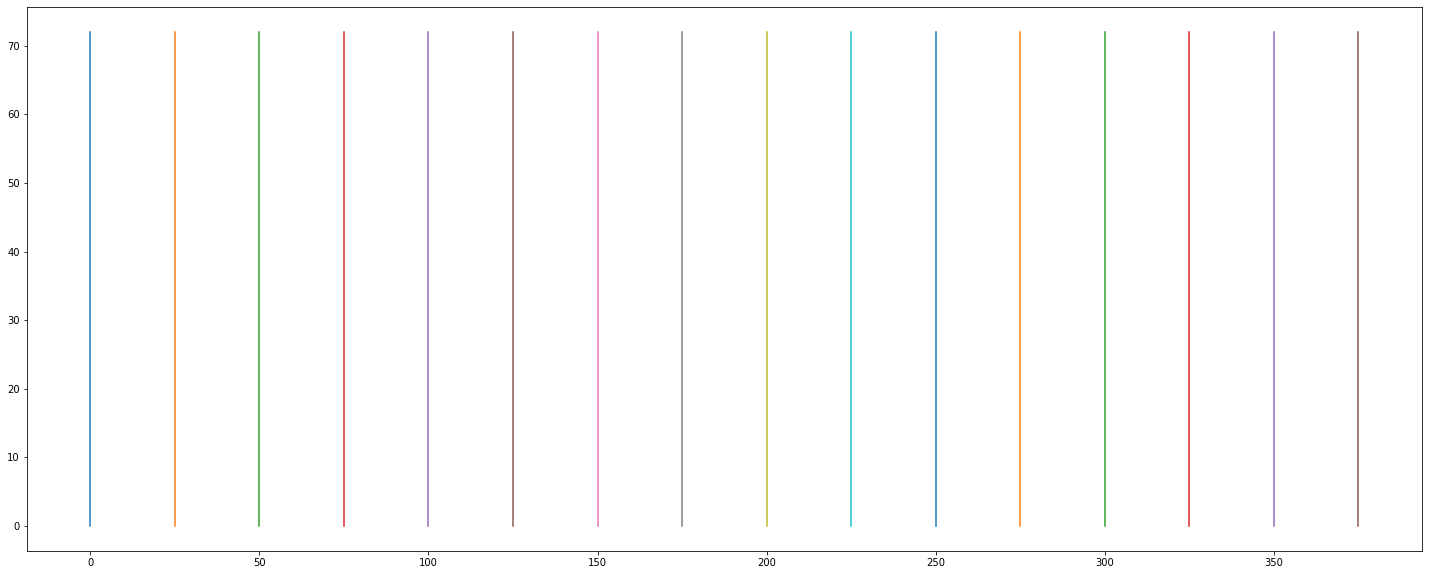

In [27]:
concrete_beam.transv_steel_bars.plotLong()

In [25]:
positive_bars.getBarTransversalPosition(self, x=)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [23]:
concrete_beam.transv_steel_bars.getTransversalBarAfterX(10)

{'x': 25.0, 'height': 72.0, 'width': 22.0, 'diameter': 0.8, 'space_after': 25.0, 'area': 1.0, 'as_per_cm': 0.04, 'anchor': 5, 'length': 225.0, 'cost': 4.629375}

In [19]:
positive_bars, negative_bars = self.long_steel_bars.getPositiveandNegativeLongSteelBarsInX(x=middle_x)

In [20]:
positive_bars

[{'long_begin': -56.67577994332125, 'long_end': 456.6757799433213, 'quantity': 6, 'diameter': 0.8, 'interspace': (-31.99999, 431.99999), 'quantity_accumulated': 6, 'area_accumulated': 3.0, 'area': 3.0, 'fyd': 43.47826086956522, 'length': 459.9798796984925, 'cost': 56.784516148778906}
 {'long_begin': -0.5551781342760229, 'long_end': 400.5551781342761, 'quantity': 2, 'diameter': 0.8, 'interspace': (-31.99999, 431.99999), 'quantity_accumulated': 8, 'area_accumulated': 4.0, 'area': 1.0, 'fyd': 43.47826086956522, 'length': 347.73867608040206, 'cost': 14.309446520708546}
]

In [13]:
positive_bars.getBarTransversalPosition(self, x=middle_x)

IndexError: index 0 is out of bounds for axis 0 with size 0

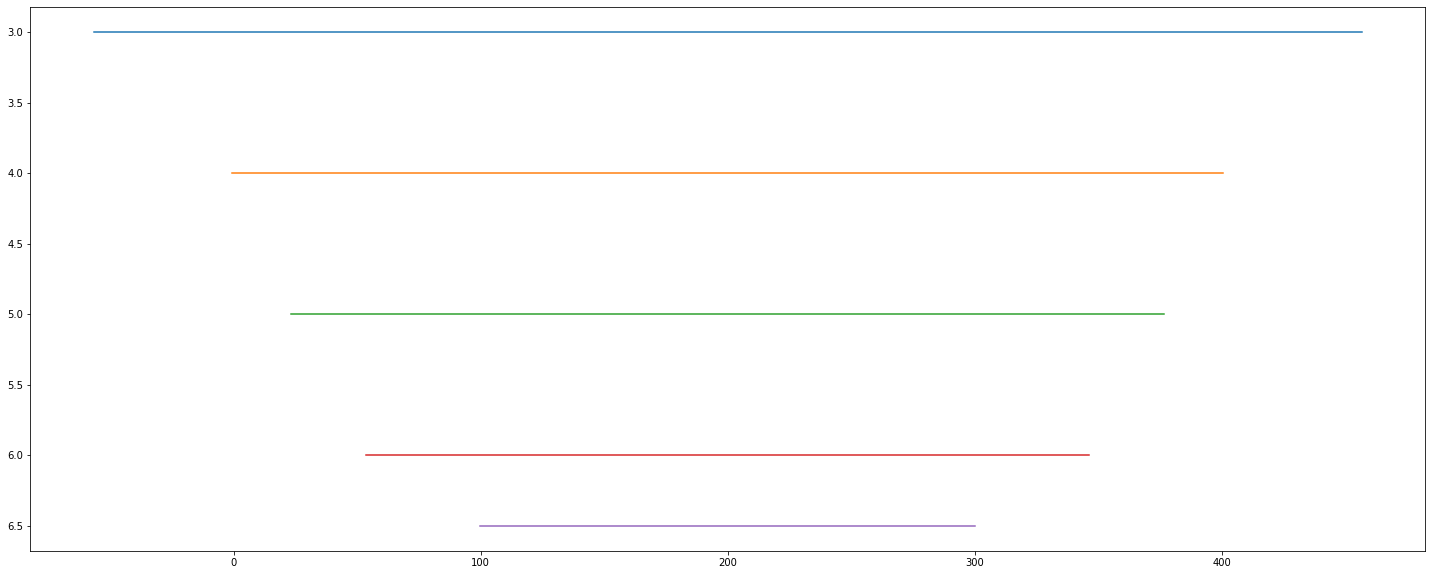

In [11]:
concrete_beam.long_steel_bars.plot()

In [10]:
middle_x

388.2976893686456

In [ ]:
negative_bars.getBarTransversalPosition()

In [16]:
 positive_bars, negative_bars = self.long_steel_bars.getPositiveandNegativeLongSteelBarsInX(x=middle_x)
positive_transversal_position, negative_transversal_position = positive_bars.getBarTransversalPosition(self, x=middle_x), negative_bars.getBarTransversalPosition(self, x=middle_x)

    tr

(array([[-9.8,  5.2,  0.4,  3. ],
        [ 9.8,  5.2,  0.4,  3. ],
        [-7. ,  5.2,  0.4,  3. ],
        [ 7. ,  5.2,  0.4,  3. ],
        [-4.2,  5.2,  0.4,  3. ],
        [ 4.2,  5.2,  0.4,  3. ],
        [-1.4,  5.2,  0.4,  3. ],
        [ 1.4,  5.2,  0.4,  3. ],
        [-9.8,  7.6,  0.4,  3. ],
        [ 9.8,  7.6,  0.4,  3. ]]),
 [])

In [13]:
for beam_element in beam_elements:
    print((beam_element.n1.x+beam_element.n2.x)/2,
          beam_element.section.positive_steel_height,
          beam_element.section.negative_steel_height,
          beam_element.section.minimum_steel_height,
          beam_element.section.maximum_steel_height)
    

56.5 0 55.800000000000004 55.800000000000004 55.800000000000004
116.56654341142095 0 55.800000000000004 55.800000000000004 55.800000000000004
122.12903229831738 55.8 55.800000000000004 55.8 55.800000000000004
153.8547070030221 55.8 55.800000000000004 55.8 55.800000000000004
189.91281494096 55.8 55.800000000000004 55.8 55.800000000000004
205.18191469626362 55.8 55.800000000000004 55.8 55.800000000000004
214.44290577288854 55.8 55.800000000000004 55.8 55.800000000000004
225.25371660371934 55.8 55.79999999999999 55.79999999999999 55.8
237.74020287999565 55.8 55.79999999999999 55.79999999999999 55.8
301.4594643843844 55.8 0 55.8 55.8
365.1787258887731 55.8 55.79999999999999 55.79999999999999 55.8
377.0706175804648 55.8 55.79999999999999 55.79999999999999 55.8
387.7733201029873 55.8 53.96470588235294 53.96470588235294 55.8
397.3086357341668 55.8 53.96470588235294 53.96470588235294 55.8
412.0912492131941 55.8 53.96470588235294 53.96470588235294 55.8
448.4696271811621 55.8 53.96470588235294 5

In [7]:
self.processing_time>0

True

(<Figure size 1800x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11bede470>)

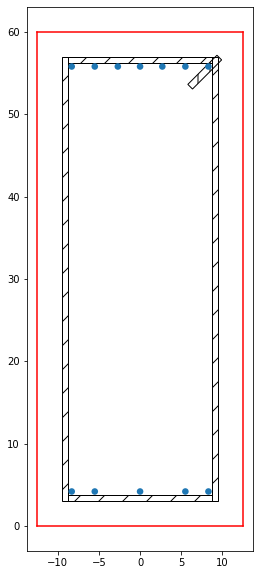

In [94]:
concrete_beam.plotTransversalInX(x=153.8547070030221)

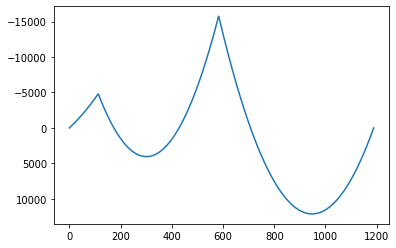

In [9]:
beam.plotMomentumDiagram()

In [23]:
beam_elements = fc.BeamElements(beam_elements)
#self.beam_elements = beam_elements
#concrete_beam = self.copy()

In [18]:
from math import radians, sin, tan


In [29]:
getDecalagedLength(beam_element)

nan

In [30]:
bw = beam_element.section.bw
d = beam_element.section.maximum_steel_height
_, s = concrete_beam.getShearDiagram(x_begin=beam_element.n1.x, x_end=beam_element.n2.x)
alpha = radians(concrete_beam.available_transv_steel_bars.inclination_angle)

In [43]:
p, n = 2, 4

In [44]:
minimum, maximum = min(p, n), max(p, n)

In [48]:
beam_element.positive_steel_height

AttributeError: 'BeamElement' object has no attribute 'positive_steel_height'

In [26]:
def getDecalagedLength(beam_element):
    """
        Returns decalaged length of a beam element.

            Call signatures:

                concrete_beam.long_steel_bars_solution_info.getDecalagedLength(beam_element)
    """ 
    bw = beam_element.section.bw
    d = beam_element.section.maximum_steel_height
    _, s = concrete_beam.getShearDiagram(x_begin=beam_element.n1.x, x_end=beam_element.n2.x)
    alpha = radians(concrete_beam.available_transv_steel_bars.inclination_angle)
    if alpha==radians(90):
        return 0.5*d
    vsd_max = max(abs(s))
    fctd = beam_element.material.fctd
    v_c0 = 0.6*fctd*bw*d
    al_formula = min(d*((vsd_max*(1+tan(alpha)**(-1)))/(2*(vsd_max-v_c0))-tan(alpha)**(-1)), d)
    if vsd_max <= v_c0:
        al = d
    elif alpha==radians(45):
        al = max(al_formula, 0.2*d)
    return al

In [27]:
x, momentum_diagram = concrete_beam.getMomentumDiagram(division=concrete_beam.division)

NameError: name 'concrete_beam' is not defined

In [28]:
decalaged_x_left = np.array([])
decalaged_x_right = np.array([])

for beam_element in concrete_beam.beam_elements:
    a_l = getDecalagedLength(beam_element)
    position_in_beam_element = x[(x>=beam_element.n1.x) & (x<=beam_element.n2.x)]
    decalaged_x_left_temp = position_in_beam_element - a_l
    decalaged_x_right_temp = position_in_beam_element + a_l
    decalaged_x_left = np.concatenate((decalaged_x_left, decalaged_x_left_temp))
    decalaged_x_right = np.concatenate((decalaged_x_right, decalaged_x_right_temp))

join_decalaged_x = np.concatenate((decalaged_x_left, x, decalaged_x_right))
join_decalaged_x_order = join_decalaged_x.argsort()
x_decalaged = join_decalaged_x[join_decalaged_x_order]

NameError: name 'concrete_beam' is not defined

In [27]:
a_l

nan

ValueError: x and y must have same first dimension, but have shapes (3000,) and (1000,)

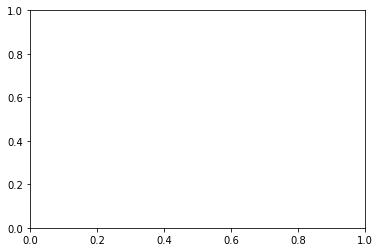

In [25]:
plt.plot(x_decalaged, decalaged_x_left)

In [5]:
self.beam_elements = beam_elements

In [6]:
self.solve_long_steel()

1187.99999
nan


../fconcrete/StructuralConcrete/LongSteelBar/LongSteelBarSolve.py:103: RuntimeWarning: invalid value encountered in less
  momentum_positive = np.where(momentum_positive<0, np.nan, momentum_positive)
../fconcrete/StructuralConcrete/LongSteelBar/LongSteelBarSolve.py:106: RuntimeWarning: invalid value encountered in greater
  momentum_negative = np.where(momentum_negative>0, np.nan, momentum_negative)
../fconcrete/Structural/Beam.py:196: RuntimeWarning: invalid value encountered in less_equal
  np.array([node.x for node in self.beam_elements.nodes]) <= x)[0][-1]


IndexError: index -1 is out of bounds for axis 0 with size 0

In [17]:
self.beam_elements.nodes.x

array([   0.,  113.,  583., 1188.])

In [ ]:
self.beam_elements = fc.BeamElements(beam_elements)

In [30]:
concrete_beam = self

In [34]:
x, momentum_diagram = concrete_beam.getMomentumDiagram(division=concrete_beam.division)

1e-05

In [47]:
x, momentum_diagram = concrete_beam.getMomentumDiagram(division=concrete_beam.division)
x_decalaged, decalaged_x_left, decalaged_x_right, join_decalaged_x_order = __decalageds_x_axis(x)
momentum_positive, momentum_negative = __decalaged_momentums(x_decalaged,
                                                            decalaged_x_left,
                                                            decalaged_x_right,
                                                            join_decalaged_x_order,
                                                            momentum_diagram)
#momentum_positive = self.__join_momentum_peak(momentum_positive)
#momentum_negative = self.__join_momentum_peak(momentum_negative)

#return x_decalaged, self.concrete_beam.design_factor*momentum_positive, self.concrete_beam.design_factor*momentum_negative
    

In [51]:
x_decalaged[np.isnan(x_decalaged)]

array([], dtype=float64)

In [46]:
def __decalageds_x_axis(x):
    decalaged_x_left = np.array([])
    decalaged_x_right = np.array([])

    for beam_element in concrete_beam.beam_elements:
        a_l = 1
        position_in_beam_element = x[(x>=beam_element.n1.x) & (x<=beam_element.n2.x)]
        decalaged_x_left_temp = position_in_beam_element - a_l
        decalaged_x_right_temp = position_in_beam_element + a_l
        decalaged_x_left = np.concatenate((decalaged_x_left, decalaged_x_left_temp))
        decalaged_x_right = np.concatenate((decalaged_x_right, decalaged_x_right_temp))

    join_decalaged_x = np.concatenate((decalaged_x_left, x, decalaged_x_right))
    join_decalaged_x_order = join_decalaged_x.argsort()
    x_decalaged = join_decalaged_x[join_decalaged_x_order]

    return x_decalaged, decalaged_x_left, decalaged_x_right, join_decalaged_x_order

In [41]:
def __decalaged_momentums(x_decalaged,
                          decalaged_x_left,
                          decalaged_x_right,
                          join_decalaged_x_order,
                          momentum_diagram):
    #momentum_decalaged_diagram = np.concatenate((momentum_diagram, momentum_diagram, momentum_diagram))[join_decalaged_x_order]

    momentum_left = np.interp(x_decalaged, decalaged_x_left, momentum_diagram)
    momentum_right = np.interp(x_decalaged, decalaged_x_right, momentum_diagram)

    momentum_positive = np.max((momentum_left, momentum_right), axis=0)
    momentum_positive = np.where(momentum_positive<0, np.nan, momentum_positive)

    momentum_negative = np.min((momentum_left, momentum_right), axis=0)
    momentum_negative = np.where(momentum_negative>0, np.nan, momentum_negative)
    return momentum_positive, momentum_negative  

In [8]:
self = beam.copy()

while True:
    x_changes = np.concatenate((self.long_steel_bars.long_begins, self.long_steel_bars.long_ends))
    x_changes = x_changes[np.isin(x_changes, self.beam_elements.nodes.x, invert=True)]
    x_changes = np.unique(x_changes[(x_changes>=0) & (x_changes<=self.length)])

    nodes_change = [ fc.Node.Crimp(x) for x in x_changes ]
    new_nodes = fc.Nodes(np.concatenate((nodes_change, self.beam_elements.nodes)))
    new_nodes = new_nodes[np.argsort(new_nodes.x)]

    previous_ds, diff = 0, 0
    beam_elements = []

    for i in range(0, len(new_nodes)-1):
        current_x = new_nodes[i].x
        next_x = new_nodes[i+1].x
        middle_x = (current_x+next_x)/2

        transversal_position = self.long_steel_bars.getBarTransversalPosition(self, x=middle_x)
        _, beam_element = self.getBeamElementInX(middle_x)
        section, material = beam_element.section, beam_element.material
        height = section.height
        
        _, y, _, area = transversal_position.T
        
        y_positive = y[y >= height/2]
        y_negative = y[y < height/2]
        
        y_c_negative = (y[y >= (height/2)] @ area[y >= (height/2)])/sum(area[y >= (height/2)]) if sum(y >= (height/2)) else np.nan
        y_c_positive = (y[y < (height/2)] @ area[y < (height/2)])/sum(area[y < (height/2)]) if sum(y < (height/2)) else np.nan
        new_positive_steel_height, previous_positive_steel_height = (height - y_c_positive), section.positive_steel_height
        new_negative_steel_height, previous_negative_steel_height = (y_c_negative), section.negative_steel_height
        
        previous_ds += 0 if np.isnan(new_positive_steel_height) else previous_positive_steel_height
        previous_ds += 0 if np.isnan(new_negative_steel_height) else previous_negative_steel_height
        diff += abs(0 if np.isnan(new_positive_steel_height) else previous_positive_steel_height-new_positive_steel_height)
        diff += abs(0 if np.isnan(new_negative_steel_height) else previous_negative_steel_height-new_negative_steel_height)

        new_section = fc.Rectangle(section.width(), section.height)
        new_section = fc.ConcreteSection.setSteelHeight(new_section, new_positive_steel_height, new_negative_steel_height)

        new_beam_element = fc.BeamElement([new_nodes[i], new_nodes[i+1]], new_section, material)
        beam_elements = [*beam_elements, new_beam_element]
    
    relative_diff_of_d = diff/previous_ds
    print(relative_diff_of_d)

    if relative_diff_of_d > self.max_relative_diff_of_steel_height:
        self.beam_elements = fc.BeamElements(beam_elements)
        self.solve_long_steel()
        self.solve_transv_steel()
        self.solve_ELS()
        self.solve_cost()
    else:
        break

0.04875000000000002
0.009596161535385868


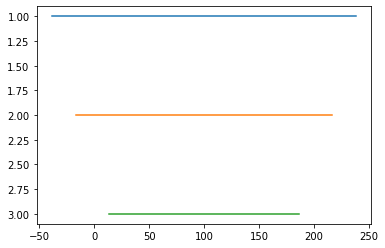

In [7]:
self.long_steel_bars.plot()

In [ ]:
fc.BeamElement()

In [ ]:
beam_elements = fc.BeamElements([])

In [20]:
previous_d, new_d

(24.77, 24.77)

In [26]:
diff/previous_ds

0.015788394504818528

In [16]:
diff

0.0

In [15]:
previous_ds

49.54

In [11]:
beam_element.section.height*.8

24.0

In [27]:
for beam_element in self.beam_elements:
    print(beam_element.section.d)

24.77
24.77
24.77


In [157]:
self.beam_elements

{'bar_elements': array([{'section': <fconcrete.Structural.Section.Rectangle object at 0x12722ffd0>, 'material': <fconcrete.StructuralConcrete.Concrete.Concrete object at 0x127248160>, 'x': [{'x': 0.0, 'condition_boundary': [0, 1], 'length': 20.0}
, {'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length': 0.0}
], 'E': 26838.405317753142, 'I': 33750.0, 'n1': {'x': 0.0, 'condition_boundary': [0, 1], 'length': 20.0}
, 'n2': {'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length': 0.0}
, 'length': 13.14199495097003, 'flexural_rigidity': 905796179.4741685},
       {'section': <fconcrete.Structural.Section.Rectangle object at 0x12722ffd0>, 'material': <fconcrete.StructuralConcrete.Concrete.Concrete object at 0x127248160>, 'x': [{'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length': 0.0}
, {'x': 186.85800504902997, 'condition_boundary': [1, 1], 'length': 0.0}
], 'E': 26838.405317753142, 'I': 33750.0, 'n1': {'x': 13.14199495097003, 'condition_boundary': [1, 1], 'length

In [121]:
middle_x

201.5667128868678

In [ ]:
beam_elements = []
nodes = self.beam_elements.nodes
for beam_element, i in zip(self.beam_elements, range(0,len(self.beam_elements)):
    beam_elements = 
    n1, n2 = self.beam_elements.nodes[i], self.beam_elements.nodes[i+1]
                           
    
    section, material = beam_element.section, beam_element.material
                           
    transversal_position = positive_bars.getBarTransversalPosition(self, x=(current_x+next_x)/2)
    _, y, _, area = transversal_position.T
    y_c = (y @ area)/sum(area)
    section.d = section.height - y_c
                           
    section.d =                  
    beam_elements = [*beam_elements, fc.BeamElement([n1, n2], section, material)]

In [31]:
>>> def concrete_beam_function(width, height, length):
...        slab_area = 5*5
...        kn_per_m2 = 5
...        distributed_load = -slab_area*kn_per_m2/500
...        pp = fc.Load.UniformDistributedLoad(-width*height*25/1000000, x_begin=0, x_end=length)
...        n1 = fc.Node.SimpleSupport(x=0, length=20)
...        n2 = fc.Node.SimpleSupport(x=400, length=20)
...        f1 = fc.Load.UniformDistributedLoad(-0.01, x_begin=0, x_end=1)
...        beam = fc.ConcreteBeam(
...            loads = [f1, pp],
...            nodes = [n1, n2],
...            section = fc.Rectangle(width, height),
...            division = 200
...        )
...        return beam
>>> full_report, solution_report, best_solution = fc.Analysis.getBestSolution(concrete_beam_function,
...                                     max_steps_without_decrease=15,
...                                     sort_by_multiplication=True,
...                                     avoid_estimate=True,
...                                     show_progress=False,
...                                     width=[15],
...                                     height=(30, 34, 2),
...                                     length=[150])
>>> # Table is sorted by cost ascending, so the first one is the most economic solution.
>>> solution_report.iloc[0]
>>> # Alternative way to look to the best solution
            

0
width                    15
height                   30
length                  150
cost                126.265
error                      
Concrete              63.59
Longitudinal bar      35.31
Transversal bar       27.36
Name: 1, dtype: object

In [36]:
print(best_solution)

{'width': 15.0, 'height': 30.0, 'length': 150.0, 'cost': 126.2650347902965, 'error': '', 'Concrete': 63.59, 'Longitudinal bar': 35.31, 'Transversal bar': 27.36}


In [ ]:
>> print(best_solution)


In [ ]:
transversal_position = positive_bars.getBarTransversalPosition(self, x=500)
x, y, radius, area = transversal_position.T
x_c = (x @ area)/sum(area) #should be always 0
y_c = (y @ area)/sum(area)